# 04. State-Level Analysis (주 수준 분석)

Lanning et al. (2022) 논문의 **축소 버전** 분석입니다.  
원래는 County-Composites (1,250개)를 사용하지만, 공개 데이터에는 **State (9개)** 수준만 있습니다.

> **Note**: "other" (이질적 집단: 41개 주 + 해외)는 제외하고 **9개 주만** 분석합니다.

## 학습 목표
- State별 성격 점수 비교
- ANOVA 분석으로 집단 간 차이 검정
- Critical Ratios로 유의미한 특징 도출 (|z|/SE > 3.0)

## 참조 파일
- `reports/stats.md` - 통계 분석 방법론
- `reports/step2_preprocess.json` - 7개 척도 목록
- `reports/step3_viz.json` - 시각화 결과

In [14]:
# 필요한 라이브러리 설치
%pip install pandas numpy matplotlib seaborn scipy -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from glob import glob
from datetime import datetime
from scipy import stats as scipy_stats

# 작업 디렉토리 설정
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print(f'작업 폴더: {os.getcwd()}')

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

작업 폴더: c:\Users\yujin\code\agent_seminar\sapa-demo


In [16]:
# reports/ 폴더의 Context 파일들 로드
print("=== 참조할 Context 파일들 ===")
for f in sorted(glob('reports/*.json')):
    print(f"  - {f}")

# Step 2 결과 로드
with open('reports/step2_preprocess.json', 'r', encoding='utf-8') as f:
    step2 = json.load(f)
scales = step2['results']['scores']['calculated_scales']
scores_file = step2['results']['scores']['output_file']
print(f"\n분석할 척도 ({len(scales)}개): {scales}")
print(f"점수 파일: {scores_file}")

=== 참조할 Context 파일들 ===
  - reports\pipeline_context.json
  - reports\step1_scan.json
  - reports\step2_preprocess.json
  - reports\step3_viz.json

분석할 척도 (7개): ['NEO_O', 'NEO_C', 'NEO_E', 'NEO_A', 'NEO_N', 'Ideology', 'Honesty_Humility']
점수 파일: data/processed/sapa_scores.csv


---
## Part 1: 데이터 로드 및 State 변수 확인

In [17]:
# 원본 데이터에서 state 변수 로드
raw_data = pd.read_csv('data/raw/sapa_data.csv', usecols=['RID', 'state'])
print(f"원본 데이터: {len(raw_data):,}명")

# 전처리된 점수 로드
scores = pd.read_csv(scores_file)
print(f"점수 데이터: {len(scores):,}명")

# 병합
df = scores.merge(raw_data, on='RID', how='left')
print(f"병합 완료: {len(df):,}명")

# "other" 제외 (이질적 집단: 41개 주 + 해외)
n_other = len(df[df['state'] == 'other'])
df = df[df['state'] != 'other']
print(f"\n✅ 'other' 제외: {n_other:,}명 제외됨")
print(f"   분석 대상: {len(df):,}명 (9개 주)")

원본 데이터: 23,679명
점수 데이터: 23,647명
병합 완료: 23,647명

✅ 'other' 제외: 16,339명 제외됨
   분석 대상: 7,308명 (9개 주)


In [18]:
# State 분포 확인 (other 제외됨)
state_counts = df['state'].value_counts()
print("=== State별 표본 수 (9개 주) ===")
print(state_counts)
print(f"\n총 {len(state_counts)}개 State, 합계 {len(df):,}명")

=== State별 표본 수 (9개 주) ===
state
California      1713
Michigan         860
Illinois         820
Texas            711
Pennsylvania     700
Florida          696
New York         684
Washington       599
Virginia         525
Name: count, dtype: int64

총 9개 State, 합계 7,308명


✅ 저장: reports/state_sample_size.png


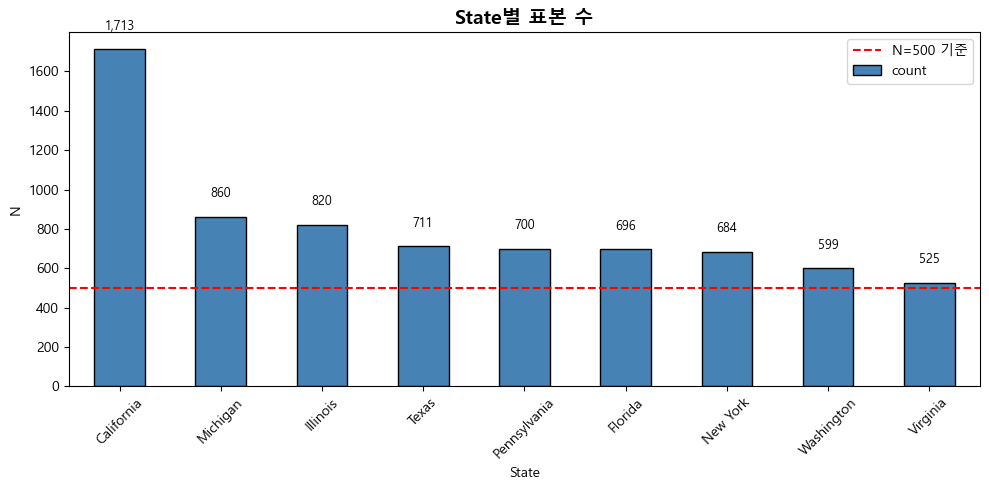

In [19]:
# State별 표본 수 시각화
fig, ax = plt.subplots(figsize=(10, 5))
state_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('State별 표본 수', fontsize=14, fontweight='bold')
ax.set_xlabel('State')
ax.set_ylabel('N')
ax.axhline(500, color='red', linestyle='--', label='N=500 기준')
ax.legend()

# 막대 위에 숫자 표시
for i, v in enumerate(state_counts.values):
    ax.text(i, v + 100, f'{v:,}', ha='center', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('reports/state_sample_size.png', dpi=150, bbox_inches='tight')
print("✅ 저장: reports/state_sample_size.png")
plt.show()

---
## Part 2: State별 기술통계 (Mean, SD, SE)

In [20]:
# State별 기술통계 계산
def calc_state_stats(df, scales, group_col='state'):
    """State별 Mean, SD, N, SE 계산"""
    results = []
    
    for state in df[group_col].unique():
        state_data = df[df[group_col] == state]
        row = {'state': state}
        
        for scale in scales:
            valid_data = state_data[scale].dropna()
            n = len(valid_data)
            mean = valid_data.mean() if n > 0 else np.nan
            std = valid_data.std() if n > 1 else np.nan
            se = std / np.sqrt(n) if n > 1 else np.nan
            
            row[f'{scale}_mean'] = mean
            row[f'{scale}_sd'] = std
            row[f'{scale}_n'] = n
            row[f'{scale}_se'] = se
        
        results.append(row)
    
    return pd.DataFrame(results).set_index('state')

state_stats = calc_state_stats(df, scales)
print("✅ State별 기술통계 계산 완료")
print(f"   Shape: {state_stats.shape}")

✅ State별 기술통계 계산 완료
   Shape: (9, 28)


In [21]:
# Big Five 평균 비교 테이블
big_five = ['NEO_O', 'NEO_C', 'NEO_E', 'NEO_A', 'NEO_N']
mean_cols = [f'{s}_mean' for s in big_five]

print("=== State별 Big Five 평균 ===")
display_df = state_stats[mean_cols].copy()
display_df.columns = big_five
display_df = display_df.round(2)
display_df

=== State별 Big Five 평균 ===


,NEO_O,NEO_C,NEO_E,NEO_A,NEO_N
state,,,,,
Illinois,4.25,4.35,4.07,4.31,3.22
New York,4.39,4.23,3.93,4.22,3.39
Michigan,4.19,4.37,3.94,4.38,3.39
California,4.30,4.25,3.90,4.26,3.32
Texas,4.26,4.25,3.92,4.30,3.32
Pennsylvania,4.29,4.31,3.97,4.27,3.43
Florida,4.28,4.37,4.01,4.30,3.20
Washington,4.26,4.24,3.99,4.29,3.31
Virginia,4.24,4.32,3.91,4.30,3.30


---
## Part 3: ANOVA 분석 (State 간 차이 검정)

각 성격 척도에서 State 간 유의미한 차이가 있는지 검정합니다.

In [22]:
# One-way ANOVA 수행
anova_results = []

for scale in scales:
    # State별 데이터 그룹화
    groups = [group[scale].dropna().values for name, group in df.groupby('state')]
    
    # ANOVA
    f_stat, p_value = scipy_stats.f_oneway(*groups)
    
    # 효과 크기 (eta-squared)
    # SSB / SST 계산
    all_data = df[scale].dropna()
    grand_mean = all_data.mean()
    ss_total = ((all_data - grand_mean) ** 2).sum()
    
    ss_between = 0
    for name, group in df.groupby('state'):
        group_data = group[scale].dropna()
        n_group = len(group_data)
        group_mean = group_data.mean()
        ss_between += n_group * (group_mean - grand_mean) ** 2
    
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    
    anova_results.append({
        'scale': scale,
        'F': f_stat,
        'p': p_value,
        'eta_squared': eta_squared,
        'significant': p_value < 0.05
    })

anova_df = pd.DataFrame(anova_results)
print("=== ANOVA 결과 (State 간 차이) ===")
print(anova_df.to_string(index=False))

=== ANOVA 결과 (State 간 차이) ===
           scale        F            p  eta_squared  significant
           NEO_O 3.610910 3.380298e-04     0.003977         True
           NEO_C 3.886582 1.382768e-04     0.004273         True
           NEO_E 3.265098 1.015908e-03     0.003606         True
           NEO_A 2.438986 1.243101e-02     0.002689         True
           NEO_N 4.701788 9.183653e-06     0.005180         True
        Ideology 3.949219 1.152749e-04     0.008693         True
Honesty_Humility 5.888507 1.625428e-07     0.011675         True


In [10]:
# 유의미한 척도 강조
sig_scales = anova_df[anova_df['significant']]['scale'].tolist()
print(f"\n✅ 유의미한 State 차이를 보이는 척도 (p < .05):")
for s in sig_scales:
    row = anova_df[anova_df['scale'] == s].iloc[0]
    print(f"   - {s}: F={row['F']:.2f}, p={row['p']:.4f}, η²={row['eta_squared']:.4f}")


✅ 유의미한 State 차이를 보이는 척도 (p < .05):
   - NEO_O: F=4.97, p=0.0000, η²=0.0019
   - NEO_C: F=9.24, p=0.0000, η²=0.0035
   - NEO_E: F=12.76, p=0.0000, η²=0.0049
   - NEO_A: F=9.48, p=0.0000, η²=0.0036
   - NEO_N: F=5.46, p=0.0000, η²=0.0021
   - Ideology: F=8.02, p=0.0000, η²=0.0061
   - Honesty_Humility: F=10.44, p=0.0000, η²=0.0073


---
## Part 4: Critical Ratios (|Mean|/SE > 3.0)

stats.md 방법론: **|z|/SE > 3.0** 기준으로 유의미한 특징 판별  
(논문 축소 버전: 전체 평균 대비 State 평균 차이를 SE로 나눔)

In [23]:
# Critical Ratio 계산
# CR = (State Mean - Grand Mean) / SE

cr_results = []

for scale in scales:
    grand_mean = df[scale].mean()
    
    for state in df['state'].unique():
        state_mean = state_stats.loc[state, f'{scale}_mean']
        state_se = state_stats.loc[state, f'{scale}_se']
        state_n = state_stats.loc[state, f'{scale}_n']
        
        if pd.notna(state_se) and state_se > 0:
            cr = (state_mean - grand_mean) / state_se
        else:
            cr = np.nan
        
        cr_results.append({
            'state': state,
            'scale': scale,
            'grand_mean': grand_mean,
            'state_mean': state_mean,
            'se': state_se,
            'n': state_n,
            'cr': cr,
            'significant': abs(cr) > 3.0 if pd.notna(cr) else False
        })

cr_df = pd.DataFrame(cr_results)
print("✅ Critical Ratio 계산 완료")

✅ Critical Ratio 계산 완료


In [24]:
# 유의미한 특징 (|CR| > 3.0) 추출
sig_cr = cr_df[cr_df['significant']].copy()
sig_cr = sig_cr.sort_values('cr', key=abs, ascending=False)

print(f"=== 유의미한 특징 (|CR| > 3.0, p < .003) ===")
print(f"총 {len(sig_cr)}개 발견\n")

if len(sig_cr) > 0:
    for _, row in sig_cr.head(15).iterrows():
        direction = "높음 ↑" if row['cr'] > 0 else "낮음 ↓"
        print(f"{row['state']:6} | {row['scale']:18} | CR={row['cr']:+6.2f} | {direction}")
else:
    print("(유의미한 특징 없음)")

=== 유의미한 특징 (|CR| > 3.0, p < .003) ===
총 8개 발견

Michigan | Honesty_Humility   | CR= +4.31 | 높음 ↑
New York | NEO_O              | CR= +3.87 | 높음 ↑
Illinois | NEO_E              | CR= +3.65 | 높음 ↑
Michigan | NEO_A              | CR= +3.34 | 높음 ↑
Florida | NEO_N              | CR= -3.22 | 낮음 ↓
Michigan | NEO_O              | CR= -3.22 | 낮음 ↓
California | Honesty_Humility   | CR= -3.21 | 낮음 ↓
California | Ideology           | CR= -3.11 | 낮음 ↓


✅ 저장: reports/state_critical_ratios.png


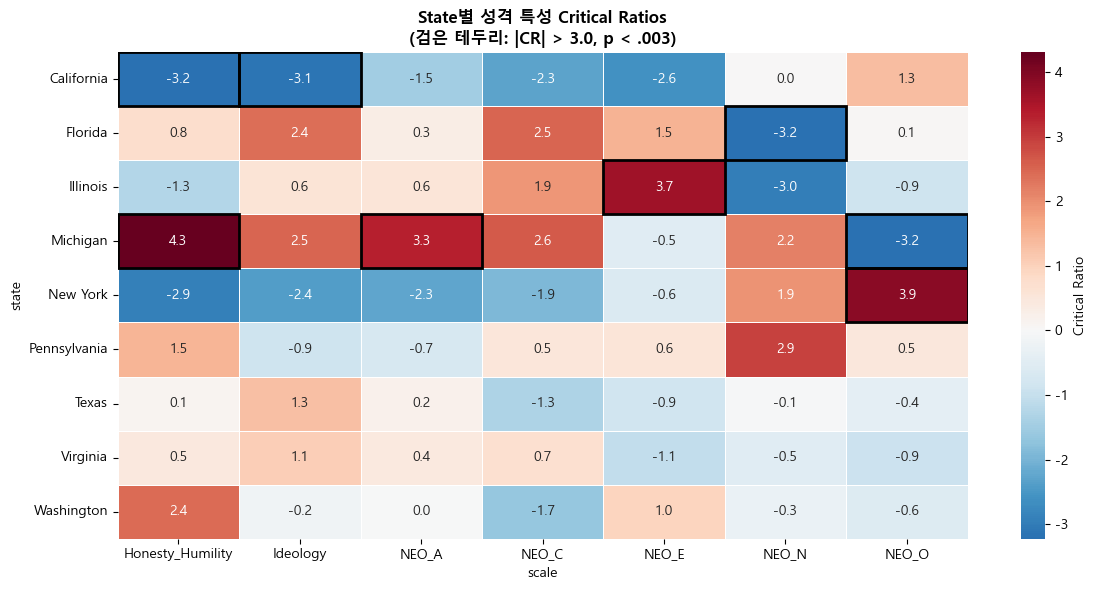

In [25]:
# Critical Ratio 히트맵
cr_pivot = cr_df.pivot(index='state', columns='scale', values='cr')

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(cr_pivot, 
            annot=True, 
            fmt='.1f', 
            cmap='RdBu_r', 
            center=0,
            linewidths=0.5,
            ax=ax,
            cbar_kws={'label': 'Critical Ratio'})

# |CR| > 3.0 셀 강조 (테두리)
for i, state in enumerate(cr_pivot.index):
    for j, scale in enumerate(cr_pivot.columns):
        if abs(cr_pivot.loc[state, scale]) > 3.0:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))

ax.set_title('State별 성격 특성 Critical Ratios\n(검은 테두리: |CR| > 3.0, p < .003)', fontsize=12, fontweight='bold')
plt.tight_layout()

plt.savefig('reports/state_critical_ratios.png', dpi=150, bbox_inches='tight')
print("✅ 저장: reports/state_critical_ratios.png")
plt.show()

---
## Part 5: State별 성격 프로필 시각화

✅ 저장: reports/state_big_five_boxplot.png


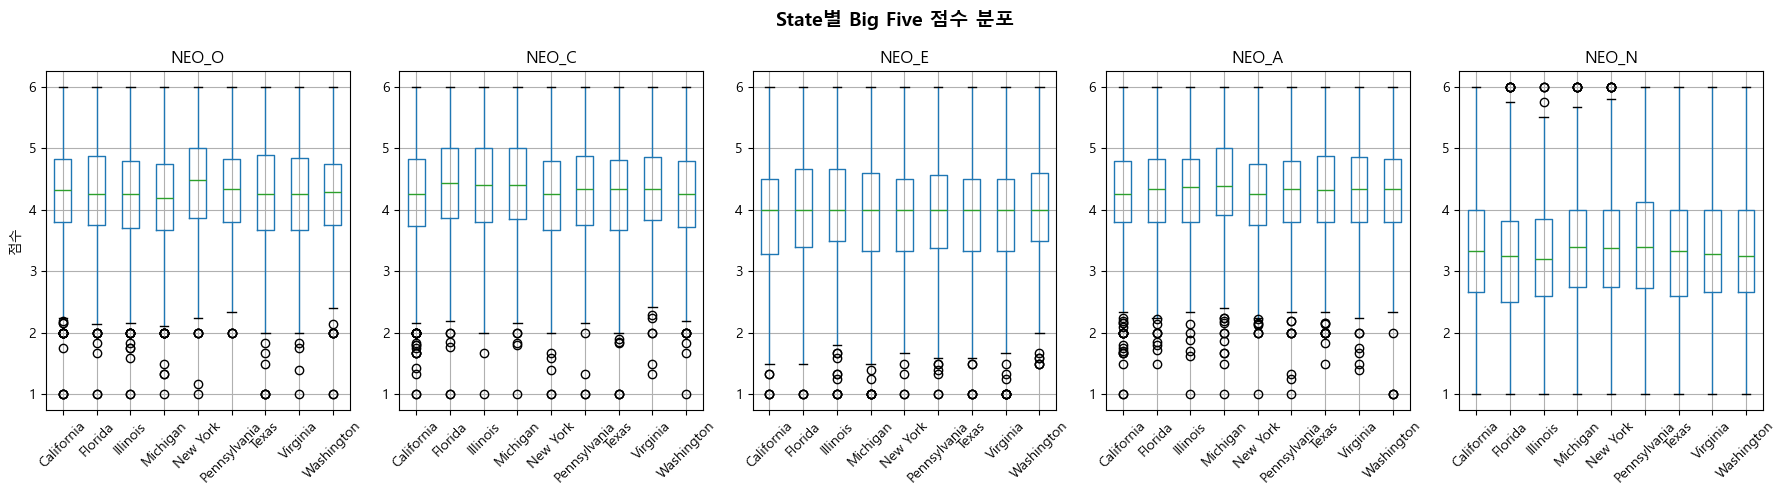

In [26]:
# Big Five 박스플롯 (State별)
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

for i, scale in enumerate(big_five):
    # State별 박스플롯
    df.boxplot(column=scale, by='state', ax=axes[i])
    axes[i].set_title(scale)
    axes[i].set_xlabel('')
    if i == 0:
        axes[i].set_ylabel('점수')
    axes[i].tick_params(axis='x', rotation=45)

fig.suptitle('State별 Big Five 점수 분포', fontsize=14, fontweight='bold')
plt.tight_layout()

plt.savefig('reports/state_big_five_boxplot.png', dpi=150, bbox_inches='tight')
print("✅ 저장: reports/state_big_five_boxplot.png")
plt.show()

✅ 저장: reports/state_profile.png


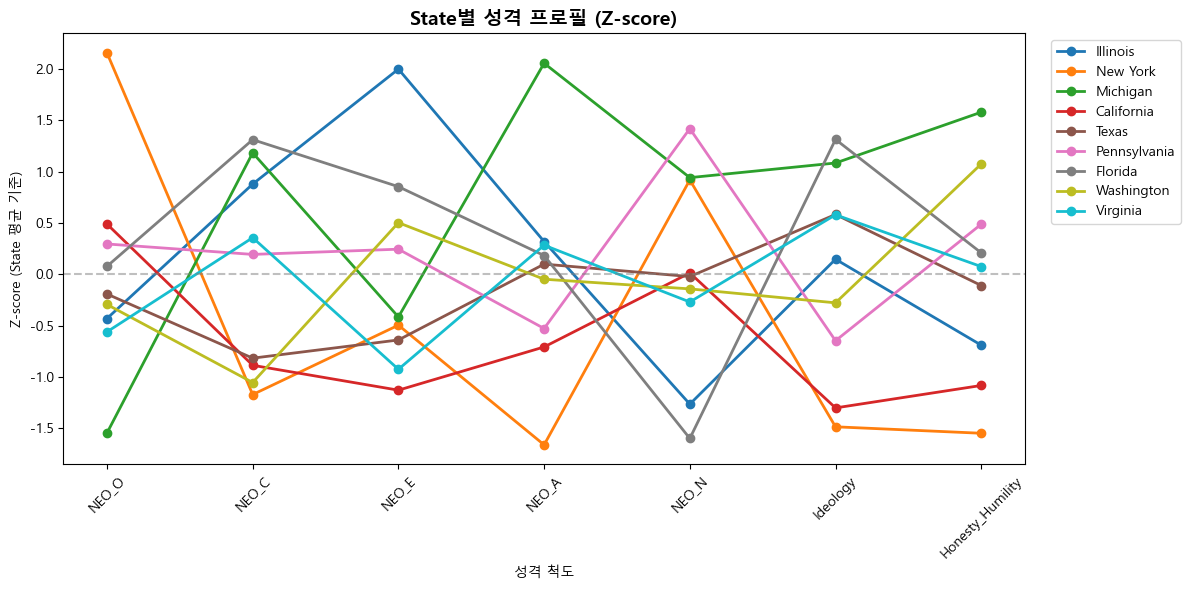

In [27]:
# State별 평균 프로필 (레이더 차트 대용: 라인 차트)
mean_df = pd.DataFrame()
for scale in scales:
    mean_df[scale] = state_stats[f'{scale}_mean']

# Z-score 변환 (척도 간 비교 용이)
mean_z = (mean_df - mean_df.mean()) / mean_df.std()

fig, ax = plt.subplots(figsize=(12, 6))

# 모든 9개 State 포함 (other는 이미 제외됨)
states_to_plot = list(mean_z.index)
colors = plt.cm.tab10(np.linspace(0, 1, len(states_to_plot)))

for i, state in enumerate(states_to_plot):
    ax.plot(scales, mean_z.loc[state], marker='o', label=state, color=colors[i], linewidth=2)

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('성격 척도')
ax.set_ylabel('Z-score (State 평균 기준)')
ax.set_title('State별 성격 프로필 (Z-score)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('reports/state_profile.png', dpi=150, bbox_inches='tight')
print("✅ 저장: reports/state_profile.png")
plt.show()